# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping

Let's get the data!

In [2]:
import re
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

# Remove punctuation and special characters
corpus_clean = [re.sub(r'[^a-zA-Z0-9\s]', '', text) for text in corpus]

# Remove stop words
stop_words = set(stopwords.words('english'))
corpus_clean = [[word for word in text.split() if word not in stop_words] for text in corpus]
corpus_clean = [' '.join(text) for text in corpus_clean] # Join the words back into a string

# Remove empty strings
corpus_clean = [text for text in corpus_clean if text.strip() != '']

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
# Initialize the tokenizer
tk = Tokenizer()
# Fit the tokenizer on the corpus
tk.fit_on_texts(corpus)
#tk.fit_on_texts(corpus_clean)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
total_words = len(tk.word_index) + 1
print(f"Total Words: {total_words}")

Total Words: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [8]:
input_sequences = []

# Iterate through each sentence in the corpus
for sentence in corpus:
    token_list = tk.texts_to_sequences([sentence])[0]   # Convert the sentence to a sequence of integers
    
    # Generate n-gram sequences
    for i in range(1, len(token_list)):             # Loop through each token
        n_gram_sequence = token_list[:i+1]          # Get n-gram sequence up to the current token
        input_sequences.append(n_gram_sequence)     # Append the n-gram sequence to the list

print(input_sequences[:10])

[[3, 2], [3, 2, 313], [3, 2, 313, 1375], [3, 2, 313, 1375, 4], [118, 1376], [118, 1376, 878], [1377, 1378], [1377, 1378, 1379], [1377, 1378, 1379, 23], [1377, 1378, 1379, 23, 1380]]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [9]:
# Calculate the longest sequence in the input_sequences list
max_sequence_len = max([len(seq) for seq in input_sequences])
print(f"Max Sequence Length: {max_sequence_len}")
# Pad all sequences to the same length
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(f"Shape of input_sequences: {input_sequences.shape}")

Max Sequence Length: 11
Shape of input_sequences: (15484, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [10]:
# Taking all rows "[:]" and all columns except the last one "[:-1]" for the predictors
predictors = input_sequences[:, :-1]
# Taking all rows "[:]" and only the last column "[-1]" for the labels
labels = input_sequences[:, -1]

One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [11]:
# Convert labels to categorical
labels = ku.to_categorical(labels, num_classes=total_words)

# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [12]:
# Embedding, LSTM, Dense, Dropout, Bidirectional
model = Sequential([
    Embedding(input_dim=total_words, output_dim=100),# input_length=max_sequence_len-1),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(total_words, activation='softmax')    
])

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [13]:
# Build the model with explicit input shape
model.build(input_shape=(None, max_sequence_len-1))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 100)        │       337,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 10, 300)        │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1687)           │       170,387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3375)           │     5,697,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,666,487 (25.43 MB)

 Trainable params: 6,666,487 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [15]:
# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, restore_best_weights=True)

In [16]:
history = model.fit(predictors, labels, epochs=50, verbose=1, callbacks=[early_stopping])

Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.0197 - loss: 7.3360
Epoch 2/50
  7/484 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.0202 - loss: 6.7875

C:\Users\Javi\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0249 - loss: 6.4987
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0246 - loss: 6.3966
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0274 - loss: 6.3252
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0365 - loss: 6.2121
Epoch 6/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0363 - loss: 6.1142
Epoch 7/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.0376 - loss: 6.0945
Epoch 8/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.0419 - loss: 6.0020
Epoch 9/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0480 - loss: 5.9391
Epoch 10/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0490 - loss: 5.8506
Epoch 11/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0561 - loss: 5.7739
Epoch 12/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0581 - loss: 5.6882
Epoch 13/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 1

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

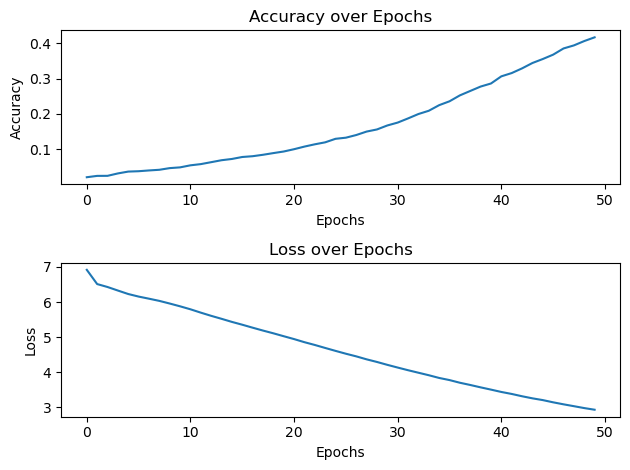

In [17]:
from matplotlib import pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

# Create a figure with two subplots
fig, axs = plt.subplots(2)

# Plot accuracy on the first subplot
axs[0].plot(acc)
axs[0].set_title('Accuracy over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

# Plot loss on the second subplot
axs[1].plot(loss)
axs[1].set_title('Loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [18]:
seed_text = "Shall I compare thee to a summer's day"
next_words = 50

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [19]:
for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tk.texts_to_sequences([seed_text])[0]
    
    # Pad the tokenized sequence to match the input length
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word (highest probability)
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)
    
    # Find the word corresponding to the predicted index
    for word, index in tk.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

print(seed_text)

Shall I compare thee to a summer's day fix'd bow near die in rest glory torn be art tend sight shall change thee there beseem such by state thee all be rare respect blest rehearse near me to me ' rotten heir sight might show rest that forth me to misuse my heart ' befits ' grow bright


Experiment with at least 3 different seed_text strings and see what happens!

In [20]:
seed_text = 'Help me Obi Wan Kenobi, you are my only hope'
next_words = 20

In [21]:
for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tk.texts_to_sequences([seed_text])[0]
    
    # Pad the tokenized sequence to match the input length
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word (highest probability)
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)
    
    # Find the word corresponding to the predicted index
    for word, index in tk.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

print(seed_text)

Help me Obi Wan Kenobi, you are my only hope pluck thee well to me keep care thou frame love rare rehearse near forth me die to art of forth


In [22]:
seed_text = "In a world where magic is real, a young girl named Alice discovers"
next_words = 20

In [23]:
for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tk.texts_to_sequences([seed_text])[0]
    
    # Pad the tokenized sequence to match the input length
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word (highest probability)
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)
    
    # Find the word corresponding to the predicted index
    for word, index in tk.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

print(seed_text)

In a world where magic is real, a young girl named Alice discovers is one of doubt ' to bring forth me none twain ' near me invited near me prove me prove


In [24]:
seed_text = 'The year is 2154, and humanity has colonized other planets.'
next_words = 20

In [25]:
for _ in range(next_words):
    # Tokenize the current seed text
    token_list = tk.texts_to_sequences([seed_text])[0]
    
    # Pad the tokenized sequence to match the input length
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # Predict the next word (highest probability)
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)
    
    # Find the word corresponding to the predicted index
    for word, index in tk.word_index.items():
        if index == predicted_word_index:
            seed_text += " " + word  # Append the predicted word to the seed text
            break

print(seed_text)

The year is 2154, and humanity has colonized other planets. in my love away of me ' rotten heir sight all new age alone fire to me grow to me
